Implementing Grid Search on keras, based on this <a href="https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/"> tutorial</a> 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("test.csv")
df = df.dropna()

In [3]:
df["ha"] = np.where(df["ha"].eq("h"),1,0)

In [4]:
X = df[['opp_goal_difference_last', 'ha', 'opp_goal_difference_5MA', 'opp_goal_difference_10MA',
       'since_last_win', 'goal_difference_5MA', 'goal_difference_10MA', 'goal_difference_last',
        'yellow_cards_referee_hist','odds_5MA', 'odds_10MA', 'odds_last'
       ]].values
y = df["class_var"]

In [5]:
class_weights = 1/y.value_counts()
class_weights = (class_weights/np.sum(class_weights))*len(class_weights)
class_weights = class_weights.to_dict()

In [8]:
class_weights[1] = 0

We split the dataset into train and test. We shuffle the examples as the order is not important here.

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

n_class_var = len(np.unique(y))

y = keras.utils.to_categorical(y, num_classes=n_class_var)

We scale with the Standard Scaler. That is the features are normalized. Models usually work better when this is the case.

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

The model's architecture. 

In [11]:
def create_model(optimizer="sgd"):
    model = keras.Sequential(
        [
            keras.layers.Dense(
                8, activation="relu", input_shape=(X.shape[-1],)
            ),
            keras.layers.Dense(12, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(8, activation="relu"),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(n_class_var, activation="softmax")
        ]
    )
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    return model

Epoch 1/20
285/285 [==============================] - 0s 2ms/step - loss: 0.5242 - accuracy: 0.3146 - val_loss: 2.0040 - val_accuracy: 0.3478
Epoch 2/20
285/285 [==============================] - 0s 906us/step - loss: 0.4608 - accuracy: 0.3502 - val_loss: 2.5153 - val_accuracy: 0.3043
Epoch 3/20
285/285 [==============================] - 0s 749us/step - loss: 0.4577 - accuracy: 0.3493 - val_loss: 2.8284 - val_accuracy: 0.3399
Epoch 4/20
285/285 [==============================] - 0s 807us/step - loss: 0.4505 - accuracy: 0.3678 - val_loss: 2.9495 - val_accuracy: 0.3320
Epoch 5/20
285/285 [==============================] - 0s 839us/step - loss: 0.4485 - accuracy: 0.3722 - val_loss: 3.1080 - val_accuracy: 0.3518
Epoch 6/20
285/285 [==============================] - 0s 829us/step - loss: 0.4431 - accuracy: 0.3678 - val_loss: 3.1755 - val_accuracy: 0.3439
Epoch 7/20
285/285 [==============================] - 0s 888us/step - loss: 0.4396 - accuracy: 0.3828 - val_loss: 3.2354 - val_accuracy: 0

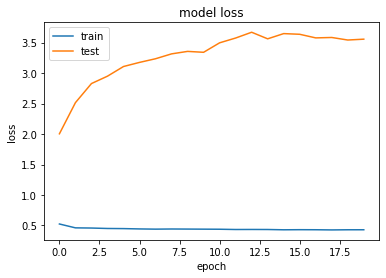

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

model = create_model(
    optimizer = keras.optimizers.SGD(
        learning_rate=0.01, momentum=0.8, nesterov=False, name="SGD"
    )
)
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=20, class_weight=class_weights)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(np.argmax(y_test, axis=1), y_pred))

print(classification_report(np.argmax(y_test, axis=1), y_pred))

0.35917721518987344
              precision    recall  f1-score   support

           0       0.27      0.64      0.38       164
           1       0.00      0.00      0.00       234
           2       0.50      0.52      0.51       234

    accuracy                           0.36       632
   macro avg       0.26      0.39      0.30       632
weighted avg       0.26      0.36      0.29       632



C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
285/285 [==============================] - 1s 2ms/step - loss: 1.0806 - accuracy: 0.4171 - val_loss: 1.0200 - val_accuracy: 0.4941
Epoch 2/10
285/285 [==============================] - 0s 850us/step - loss: 1.0400 - accuracy: 0.4747 - val_loss: 0.9978 - val_accuracy: 0.4941
Epoch 3/10
285/285 [==============================] - 0s 903us/step - loss: 1.0319 - accuracy: 0.4901 - val_loss: 0.9955 - val_accuracy: 0.5138
Epoch 4/10
285/285 [==============================] - 0s 761us/step - loss: 1.0193 - accuracy: 0.4897 - val_loss: 0.9929 - val_accuracy: 0.5059
Epoch 5/10
285/285 [==============================] - 0s 764us/step - loss: 1.0199 - accuracy: 0.4998 - val_loss: 0.9922 - val_accuracy: 0.5296
Epoch 6/10
285/285 [==============================] - 0s 768us/step - loss: 1.0158 - accuracy: 0.4985 - val_loss: 0.9945 - val_accuracy: 0.5099
Epoch 7/10
285/285 [==============================] - 0s 776us/step - loss: 1.0202 - accuracy: 0.4998 - val_loss: 0.9969 - val_accuracy: 0

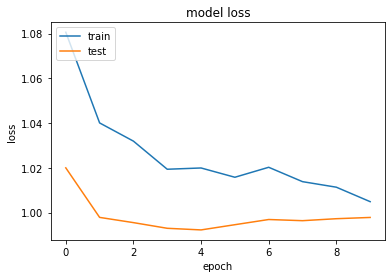

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

model = create_model(optimizer="adam")
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=10)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(np.argmax(y_test, axis=1), y_pred))

print(classification_report(np.argmax(y_test, axis=1), y_pred))

0.509493670886076
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.50      0.73      0.59       234
           2       0.52      0.65      0.58       234

    accuracy                           0.51       632
   macro avg       0.34      0.46      0.39       632
weighted avg       0.38      0.51      0.43       632



C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flis1\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [1, 4, 8]
epochs = [10, 20]
optimizers = ['SGD', 'Adam']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3)
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END batch_size=1, epochs=10, optimizer=SGD;, score=0.521 total time=  11.1s
[CV 2/5] END batch_size=1, epochs=10, optimizer=SGD;, score=0.446 total time=  10.9s
[CV 3/5] END batch_size=1, epochs=10, optimizer=SGD;, score=0.524 total time=  12.7s


KeyboardInterrupt: 

In [ ]:
accuracy_score(grid.best_estimator_.predict(X_test), np.argmax(y_test, axis=1))

In [ ]:
grid.best_params_